## **From last episode**

In [1]:
import quandl
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

quandl.ApiConfig.api_key = "Hzq3sWp4zmh3syzmcNQA"    ## set api_key to access quandl data

df = quandl.get("WIKI/MSFT")
print(f'Original DataFrame:\n')
print(df.head())

# Select only the split-adjusted column data
df = df[['Adj. Open', 'Adj. Close', 'Adj. High', 'Adj. Low', 'Adj. Volume']]

# To get more useful data
# Add new percentage columns by manipulating current columns
df['HighLowPct'] = (df['Adj. High'] - df['Adj. Low'])/ df['Adj. Low'] * 100.0
df['DayChangePct'] = (df['Adj. Close'] - df['Adj. Open'])/ df['Adj. Open'] * 100.0

# Agian, select these new columns along w/ the volume column
df = df[['Adj. Close', 'DayChangePct', 'HighLowPct', 'Adj. Volume']]
print(f'Modified DataFrame:\n')
df.head()

Original DataFrame:

             Open   High   Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                         
1986-03-13  25.50  29.25  25.5  28.00  3582600.0          0.0          1.0   
1986-03-14  28.00  29.50  28.0  29.00  1070000.0          0.0          1.0   
1986-03-17  29.00  29.75  29.0  29.50   462400.0          0.0          1.0   
1986-03-18  29.50  29.75  28.5  28.75   235300.0          0.0          1.0   
1986-03-19  28.75  29.00  28.0  28.25   166300.0          0.0          1.0   

            Adj. Open  Adj. High  Adj. Low  Adj. Close   Adj. Volume  
Date                                                                  
1986-03-13   0.058941   0.067609  0.058941    0.064720  1.031789e+09  
1986-03-14   0.064720   0.068187  0.064720    0.067031  3.081600e+08  
1986-03-17   0.067031   0.068765  0.067031    0.068187  1.331712e+08  
1986-03-18   0.068187   0.068765  0.065876    0.066454  6.776640e+07  
1986-0

,Adj. Close,DayChangePct,HighLowPct,Adj. Volume
Date,,,,
1986-03-13,0.064720,9.803922,14.705882,1.031789e+09
1986-03-14,0.067031,3.571429,5.357143,3.081600e+08
1986-03-17,0.068187,1.724138,2.586207,1.331712e+08
1986-03-18,0.066454,-2.542373,4.385965,6.776640e+07
1986-03-19,0.065298,-1.739130,3.571429,4.789440e+07


In [2]:
import math

# Add a label column for our prediction, also fill in some already known data by shifting
predict_col = 'Adj. Close'                    ## what do you want to predict
df.fillna(value=-99999, inplace=True)
days_to_predict = int(math.ceil(0.01*len(df)))    ## How many days do you want to predict

df['label'] = df[predict_col].shift(-days_to_predict)    ## Q) Shifting? Why not just delete the last 20 data?
df.dropna(inplace=True)
df.head()

,Adj. Close,DayChangePct,HighLowPct,Adj. Volume,label
Date,,,,,
1986-03-13,0.064720,9.803922,14.705882,1.031789e+09,0.064720
1986-03-14,0.067031,3.571429,5.357143,3.081600e+08,0.062986
1986-03-17,0.068187,1.724138,2.586207,1.331712e+08,0.064720
1986-03-18,0.066454,-2.542373,4.385965,6.776640e+07,0.063842
1986-03-19,0.065298,-1.739130,3.571429,4.789440e+07,0.064720


### **Preprocessing**
1. Define Feature and Label
2. Split data into training set & testing set
3. [Scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html) "training data" --> Standardize a dataset along any axis

In [3]:
# It's typical in ML code to define:
# X as the features, and y as the label
X = np.array(df.drop(['label'], axis=1))
y = np.array(df['label'])
print(f'{X[0]} & {y[0]}')

# Scale the feature data
X = preprocessing.scale(X)

# Split into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

[6.47199796e-02 9.80392157e+00 1.47058824e+01 1.03178880e+09] & 0.064719979622


### **Training**
1. Choose your model
2. Fit training features and training labels
3. Test accuracy


In [4]:
svm_model = svm.SVR(kernel='linear')
svm_model.fit(X_train, y_train)

SVR(kernel='linear')

In [5]:
svm_accuracy = svm_model.score(X_test, y_test)
print(f'svm_accuracy = {svm_accuracy}')

svm_accuracy = 0.9709449682704259


In [6]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

LR_accuracy = LR_model.score(X_test, y_test)
print(f'LR_accuracy = {LR_accuracy}')

LR_accuracy = 0.9712773547127478


- Some of the ML algorithms will process one step at a time, with no threading, others can thread and use all the CPU cores available
    - If it has **n_jobs**, you have an algorithm that can be threaded for high performance. If not, tough luck! Thus, if you are processing massive amounts of data, or you need to process medium data but at a very high rate of speed, then you would want something threaded.
    - svm don't support thread, LR does!

In [7]:
LR_model_threaded = LinearRegression(n_jobs=-1)
LR_model_threaded.fit(X_train, y_train)

LR_model_threaded_acc = LR_model_threaded.score(X_test, y_test)
print(f'LR_threaded_accuracy = {LR_model_threaded_acc}')

LR_threaded_accuracy = 0.9712773547127478


## **Forecasting**
- Use our model to do some predictions!
- Since we're forcasting 1% of the data, we will want to "at least" generate forecasts for each of the final 1% of the dataset.
    - When can we do this? When would we identify that data? We could call it now, but consider the data we're trying to forecast is not scaled like the training data was...
    - The scale method scales based on all of the known data that is fed into it. **Ideally, you would scale both the training, testing, AND forecast/predicting data all together**
    -  In our case, we can do it now. Our data is small and the processing time is low enough, so we'll preprocess and scale the data all at once.
        - In many cases, you WONT be able to do this. Imagine if you were using gigabytes of data to train a classifier. It may take days to train your classifier, you wouldn't want to be doing this every...single...time you wanted to make a prediction ==>  Thus, you may need to **either NOT scale anything, or you may scale the data separately**
        
With the above in mind, let's handle all of the rows from the definition of X onward:

- **Rerun from the beginning since we're redefining our X as X[:-forecast_out]**

    - **Take all data, preprocess it, then split it up**
    - **X_lately variable contains the most recent features**, which we're going to predict against

In [8]:
# Re-import some of the modules used
import quandl
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [9]:
quandl.ApiConfig.api_key = "Hzq3sWp4zmh3syzmcNQA"

df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

print(f'{len(X)} & {len(y)}')

3389 & 3389


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
LR_model_2 = LinearRegression(n_jobs=-1)
LR_model_2.fit(X_train, y_train)

LR_model_2_acc = LR_model_2.score(X_test, y_test)
print(LR_model_2_acc)

0.9794210785883601


## **Predicting**

In [11]:
predict_set = LR_model_2.predict(X_lately)

print(predict_set)
print(LR_model_2_acc, forecast_out)

[1104.65072797 1072.96503156 1019.0397463  1061.21376527 1074.26532812
 1074.92041952 1093.58301586 1111.90185334 1116.40971138 1124.5249565
 1134.23216198 1130.35163749 1149.74689459 1165.95664127 1136.56950445
 1123.26986568 1087.90731587 1104.71259522 1115.77940205 1122.30473239
 1136.74623942 1151.51647357 1182.87657227 1187.47801952 1158.00215861
 1170.45657342 1171.62506215 1153.93997701 1118.82153557 1115.84060778
 1114.53888537 1070.39604439 1043.25083031 1072.00162692 1019.7259753 ]
0.9794210785883601 35


## **Visualizing**
- prices are daily, for 5 days, and no prices on the weekends => We choose to keep it simple by just plotting it out without considering weekend gaps

In [12]:
import datetime
import matplotlib.pyplot as plt
from matplotlib import style

In [13]:
style.use('ggplot')

Next, we're going to add a new column to our dataframe, **the forecast column**:

In [14]:
df['Forecast'] = np.NaN

- set the value as a NaN first, but we'll populate some shortly
- We said we're going to start the forecasts as of tomorrow 
    - Recall that we predict 10% out into the future, and we saved the last 10% of our data to do this, thus, we can begin immediately predicting since -10% has data that we can predict 10% out and be the next prediction). 
 
    - We need to:
        1. first **grab the last day in the dataframe**
        2. begin **assigning each new forecast to a new day**

In [15]:
df.iloc[-1]    # Select the last row with iloc[-1]

Adj. Close     1.068760e+03
HL_PCT         5.450241e+00
PCT_change    -2.893850e+00
Adj. Volume    3.742469e+06
label          1.006940e+03
Forecast                NaN
Name: 2018-02-05 00:00:00, dtype: float64

In [16]:
DAY_TO_SEC = 86400

latest_date = df.iloc[-1].name
latest_date_unix = latest_date.timestamp()
next_date_unix = latest_date_unix + DAY_TO_SEC*1    # Get the next day's unix timestamp

Now we add the forecast to the existing dataframe

All we're doing is:
   1. iterating through the forecast set
   2. taking each forecast and day, and then setting those values in the dataframe (making the future "features" NaNs). 
   3. The last line's code just simply takes all of the first columns, setting them to NaNs, and then the final column is whatever i is (the forecast in this case)

In [17]:
# Logging the date
print(f'Current data till {df.index.tolist()[-1]}')
next_date = datetime.datetime.fromtimestamp(next_date_unix)
print(f'next_date is {next_date}')


for i in predict_set:
    next_date = datetime.datetime.fromtimestamp(next_date_unix)
    next_date_unix += DAY_TO_SEC
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

Current data till 2018-02-05 00:00:00
next_date is 2018-02-06 08:00:00


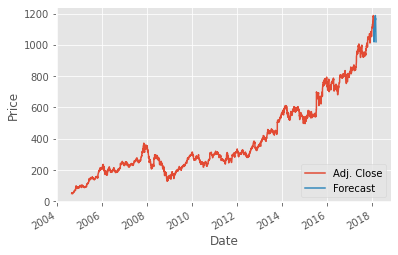

In [18]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()